# Lab05 - Autoencoders for digit reconstruction

In this assignment we will build an autoencoder to that will reconstruct digits from in the MNIST datset.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

from tqdm import tqdm


# Import my functions and classes
from autoencoder_structure import Autoencoder
import testing_tools
import corrupt_data


### If cuda is available set the device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = torch.device("cpu")
print('Device:', device)


Device: cuda


In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = MNIST('../datasets', train=True,  download=True, transform=train_transform)
test_dataset  = MNIST('../datasets', train=False, download=True, transform=test_transform)

# Define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Plot some sample from the dataset

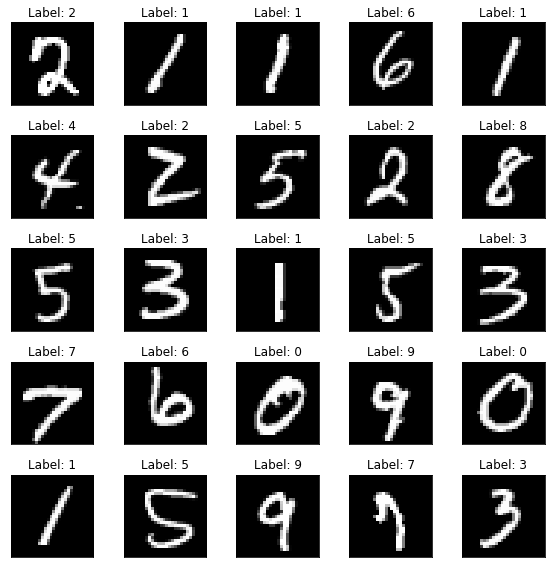

In [3]:
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Autoencoder class

Initialize the network and test it on some examples to check its output shape (we want it to be equal to the input shape)

In [8]:
### Initialize the network
encoded_space_dim = 4
net = Autoencoder(encoded_space_dim, device, dropout=0.3)
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.to(device)


### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0).to(device)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


## Train the model
To perform the different trainings, the following procedures will call the `train_epoch()` and `test_epoch()` methods of the `Autoencoder` class.

### Training with Random Search

Here we will search the best hyperparameters tuning the learning process through a Random Search. In particular we will search for the best values of `lr`,`weight_decay` and `dropout`. The following class has to generate combinations of those parameters, sampling them from their correspondent distribution.

In [5]:
# Class that generates random combinations of the 
# parameters to perform the random search
class Param_generator():
    
    def __init__(self, drop_limits, lr_limits, L2_limits):
        
        self.drop_min = drop_limits[0]
        self.drop_max = drop_limits[1]
        self.lr_min_exp = lr_limits[0]
        self.lr_max_exp = lr_limits[1]
        self.L2_min_exp = L2_limits[0]
        self.L2_max_exp = L2_limits[1]    
        
        
    def gen_values(self, n_combins):
        
        drop_vals = np.random.uniform(self.drop_min, self.drop_max, n_combins)
        lr_vals = 10**(np.random.uniform(self.lr_min_exp, self.lr_max_exp, n_combins))
        L2_vals = 10**(np.random.uniform(self.L2_min_exp, self.L2_max_exp, n_combins))              
        
        combins_list = [ (drop_vals[i], lr_vals[i], L2_vals[i]) for i in range(n_combins)]
        return combins_list

    
# Initialize parameters generator giving the bounds of each distribution, the optims and their probs
pars_generator = Param_generator( [0,0.6], [-4,-1], [-6,-2] )

Here we will perform the Random Search by defining and training a network for each combination of parameters: The best one will be kept for the following points of the exercise.

In [ ]:
# Define a loss function
loss_fn = torch.nn.MSELoss()

# generate combinations of paramereters and prepare scores array
params_combinations = pars_generator.gen_values(30)
all_scores = np.zeros(len(params_combinations))

# other params for training
encoded_space_dim = 4
num_epochs = 60
best_score = 1000000 #arbitrary big number



####### RANDOM SEARCH #######
print('Starting Random Search process')
start = time.time()

for i in range(len(params_combinations)):
    
    # Extact params
    dropout, lr, L2_decay = params_combinations[i]
    
    # Generate the network
    net = Autoencoder(encoded_space_dim, device, dropout)
    net.to(device)

    # Define an optimizer
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_decay)

    ### Train the model
    for epoch in range(num_epochs):
        net.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optim=optim, log=False) 

    # Compute final validation loss
    test_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn)
    
    # Print and store final loss value
    all_scores[i] = test_loss
    print('\nNetwork trained with: Dropout =',dropout,', lr =',lr,', L2_decay =',L2_decay)
    print('Final loss value: \t', test_loss)
    
    # If this is the best score, keep model as the best one
    if test_loss < best_score:
        best_net = net
        best_score = test_loss
        

    
# Print time needed to complete Random Search
finish = time.time()
print('\n\n Random Search process took', int(finish-start), 'seconds')

# Sort scores from best to worst and the combinations accordingly
sorted_scores, sorted_params = zip(*sorted(zip(all_scores, params_combinations),reverse=True))
print('\n\nBest combination of training params is', sorted_params[0])

# Store Best Network weights       
torch.save(net.state_dict(), 'best_net_params_4.pth')

# Save the sorted scores and params combinations in 2 files
with open('sorted_scores.dat', 'w') as f:
    for item in sorted_scores:
        f.write("%s\n" % item)
        
with open('sorted_params.dat', 'w') as f:
    for item in sorted_params:
        f.write("%s,%s,%s\n" % item)

Starting Random Search process

Network trained with: Dropout = 0.19916777384683357 , lr = 0.013907470180713241 , L2_decay = 0.0003225998608423782
Final loss value: 	 tensor(0.0624)

Network trained with: Dropout = 0.5415932465959474 , lr = 0.00044357182617396455 , L2_decay = 0.001477749864153608
Final loss value: 	 tensor(0.0692)

Network trained with: Dropout = 0.1755787939991402 , lr = 0.01170634146073832 , L2_decay = 0.00503069845762583
Final loss value: 	 tensor(0.0973)

Network trained with: Dropout = 0.46436109887134747 , lr = 0.025554566941720903 , L2_decay = 0.0003529469993390415
Final loss value: 	 tensor(0.0688)

Network trained with: Dropout = 0.401310596594409 , lr = 0.053794951615432456 , L2_decay = 0.0016432936391679422
Final loss value: 	 tensor(0.0701)

Network trained with: Dropout = 0.17269033958165517 , lr = 0.003326678884335614 , L2_decay = 0.009537568305161415
Final loss value: 	 tensor(0.0986)

Network trained with: Dropout = 0.4392781254946586 , lr = 0.000249208

After finding the bet combination of hyperparameters to train the network, retrain it with more epochs too obtain the "final" model.

In [ ]:
# Take best params from above
dropout, lr, L2_decay = params_combinations[i]

# Generate the network
net = Autoencoder(encoded_space_dim, device, dropout)
net.to(device)

# Define an optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_decay)

### Train the model
for epoch in range(num_epochs):
    
    net.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optim=optim, log=False) 

    # Compute final validation loss
    test_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn)
    # Print Validation loss
    print('\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

### Save trained model as the best one
torch.save(net.state_dict(), 'best_net_params_4.pth')

In [ ]:
# If training was done in the past, you can load the trained network
net = Autoencoder(4, device)
net.load_state_dict(torch.load('best_net_params_4.pth'))
net.to(device)

### Test model with corrupted data
Use the testing tools (defined in the corresponding python script) to see how the model reconstruct corrupted data

In [ ]:
# Generate the corrupted datasets
noise_data = corrupt_data.Gauss_noised_dataset(test_dataset)
obscure_data = corrupt_data.Obscured_dataset(test_dataset)

In [ ]:
### GAUSSIAN NOISE ###
# Plot one sample next to the reconstructed one
testing_tools.plot_comparison(net, noise_data[0])

In [ ]:
### OCCLUSION ###
# Plot one sample next to the reconstructed one
testing_tools.plot_comparison(net, obscure_data[0])

### Performance for different sizes of the hidden layer
Now we will use the `best_params` find before to train networks with different sizes of the hidden layer (we will go from 1 to 10) to check how this will impact the performances.

In [ ]:
# Take best training params 
dropout = 0.4
lr = 0.001
L2_decay = 0.00005

loss_fn = torch.nn.MSELoss()
num_epochs = 100

# Prepare array that will contain the final losses for each architecture 
final_losses = np.zeros(10)


for hidden_size in range(1,11):
    
    # Generate the network
    net = Autoencoder(hidden_size, device, dropout)
    net.to(device)

    # Define an optimizer
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_decay)

    ### Train the model
    for epoch in range(num_epochs):
        net.train_epoch(train_dataloader, loss_fn, optim, log=False) 

    # Compute final validation loss
    test_loss = net.test_epoch(dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim) 
    final_losses[hidden_size-1] = test_loss 
    print('Network with',hidden_size,'hidden neurons : ',test_loss)

In [ ]:
# Plot losses
plt.close('all')
plt.plot(final_losses, label='Final loss values')
plt.xlabel('Size of the hidden layer')
plt.ylabel('Loss')
#plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

### Train Denoising autoencoder
In order to train a denoising autoencoder, we need to build a new dataset containing both the original and the corrupted data. In this way the Dataloader will build samples containing both versions of each image.

In [5]:
class combined_dataset(Dataset):
    
    # Initialize the dataset
    def __init__(self, orig_data, std_noise=0.1):
        
        # Generate corrupted dataset
        noised_data = corrupt_data.Gauss_noised_dataset(orig_data, std_noise=0.1)
        
        # Store datasets
        self.orig_dataset = orig_data        
        self.noised_dataset = noised_data
        
        
    # This function returns the noised sample, the original one and the label
    def __getitem__(self, idx):
              
        noised_image = self.noised_dataset[idx][0]
        orig_image = self.orig_dataset[idx][0]  
        label = self.orig_dataset[idx][1]
        return (noised_image, orig_image, label)
    
    # Function that defines the length of the dataset
    def __len__(self):
        return len(self.orig_dataset)

    
# Initialize Datasets and their dataloaders
combined_train_dataset = combined_dataset(train_dataset)
combined_test_dataset = combined_dataset(test_dataset)
combined_train_dataloader = DataLoader(combined_train_dataset, batch_size=512, shuffle=True)
combined_test_dataloader = DataLoader(combined_test_dataset, batch_size=512, shuffle=False)

KeyboardInterrupt: 

In [ ]:
# Generate the network
net = Autoencoder(encoded_space_dim, device, dropout)
net.to(device)

# Define parameters
dropout = 0.2
lr = 0.002
L2_decay = 0.00001

# Define a loss function
loss_fn = torch.nn.MSELoss()
    
# Define an optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_decay)

num_epochs = 60

### TRAIN THE NETWORK

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    ### Training
    net.train_epoch(composed_train_dataloader, loss_fn, optim, denoise_mode=True) 

    ### Validation
    val_loss = net.test_epoch(composed_test_dataloader, loss_fn, denoise_mode=True) 
    # Print Validation loss
    print('VALIDATION - EPOCH %d/%d - loss: %f\n' % (epoch + 1, num_epochs, val_loss))

In [ ]:
# Check how the new model denoise data by plotting the filtered samples
idx = 42
testing_tools.plot_comparison(net, composed_test_dataset[idx])

### Check smooth sampling from latent space
First of all, we should check the distributions of each component of the encodent representation of the data. 

In [8]:
# If network is not loaded, load it
net = Autoencoder(4, device)
net.load_state_dict(torch.load('best_net_params_4.pth'))
net.to(device)

Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): Dropout(p=0, inplace=False)
    (8): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose

In [9]:
# Get encoded distribution of the test dataset
encoded_images = net.get_enc_representation(test_dataset)   

100%|██████████| 10000/10000 [00:08<00:00, 1157.81it/s]


Feature number 0
	Mean = -4.3181796
	STD  = 8.040879


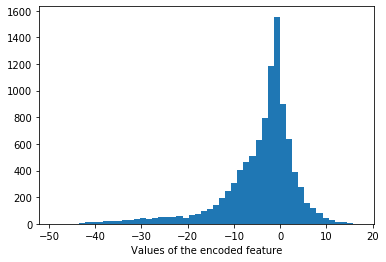

Feature number 1
	Mean = 1.4757192
	STD  = 7.146776


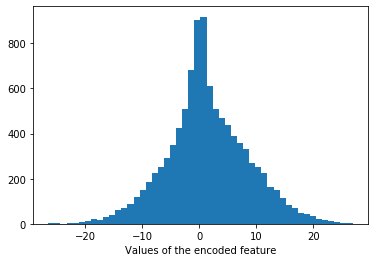

Feature number 2
	Mean = 0.13344988
	STD  = 9.342769


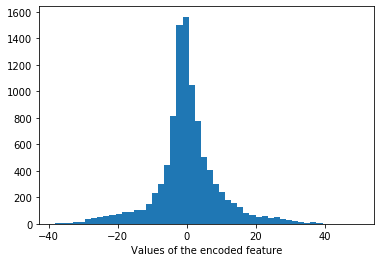

Feature number 3
	Mean = 0.3470442
	STD  = 6.9435143


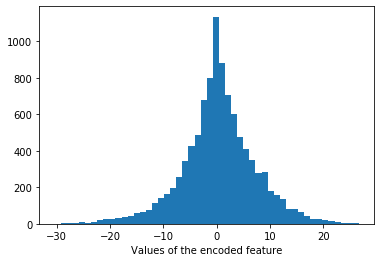

In [11]:
# Plot 4 histograms (one for each encoded feature)
for i in range(4):
    
    print('Feature number', i)
    print('\tMean =', np.mean(encoded_images[:,i]))
    print('\tSTD  =', np.std(encoded_images[:,i]))
    plt.hist(encoded_images[:,i], bins=50)
    plt.xlabel('Values of the encoded feature')
    plt.show()

Now we can choose two points, consider the line that connects them. Take many equidistant points on it and decode the correspondent sample. We will see if there is a smooth evolution of these samples.

In [19]:
import imageio

# Define starting and ending point of the evolution as (mean-std, mean+std)
mean_vals = encoded_images.mean(axis=0)
std_vals = encoded_images.std(axis=0)
start = mean_vals - std_vals/5
finish = mean_vals + std_vals/5

# Compute array with intermediate points
n_points = 100
middle_points = np.array([ np.linspace(start[0], finish[0], n_points), 
                           np.linspace(start[1], finish[1], n_points),    
                           np.linspace(start[2], finish[2], n_points),    
                           np.linspace(start[3], finish[3], n_points) ])

# Decode every intermediate point and store the correspondent image in a temp folder
os.makedirs('tmp_gif_dir')
for i in range(n_points):
    filename = 'tmp_gif_dir/image_'+str(i).zfill(2)+'.png'
    net.generate_from_encoded_sample(middle_points[:,i], filename)

# Order all filenames
all_filenames = os.listdir('tmp_gif_dir')
all_filenames = sorted(all_filenames)

# Build the GIF and store it
images = []
for filename in all_filenames:
    images.append(imageio.imread('tmp_gif_dir/'+filename))
imageio.mimsave('smooth_sampling_evolution.gif', images)
print('GIF is stored')

# Delete temp files and folder
for filename in all_filenames:
    os.remove('tmp_gif_dir/'+filename)
os.rmdir('tmp_gif_dir/')

GIF is stored
